In [1]:
%matplotlib inline

import numpy as np
import copy
import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim
seed = cfg_seed
env_str=cfg_env
# num_iter_max=200000
env_name = 'CustomPendulum-v0'
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter3_"

loss_list = []
normalized_loss_list = []
print("seed",seed)

print(datetime.datetime.now())

seed 2
2023-07-03 07:54:15.180561


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)

2 1 1


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/proxima-hishinuma/anaconda3/

In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_weightedvae2_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_pendulum_bamdp_weightedvae2_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

# iwvi.load_base(ckpt_key="unweighted")
iwvi.load(ckpt_key="policy_optimization_iter2")

dec: h_dim 48
iwvi load ckpt1, ckpt2 ckpt_iwvi_basepartpendulum_policy_optimization_iter2 ckpt_iwvi_pendulum_policy_optimization_iter2
base load ckpt ckpt_basevi_pendulum_policy_optimization_iter2
base load self.initial_belief.data.sum() tensor(-0.4056)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(-9.2377)
penalty_target_min tensor(-6.1621) penalty_target_max tensor(14.9520)
train_loss:  -5.205297948770225
valid_loss:  -4.830881930732728
h_min_tilde -6.162122 ell_tilde -5.130414745162725 kappa_tilde 0.0009845137944339349
success load ckpt_iwvi_basepartpendulum_policy_optimization_iter2
train_loss:  -1.0888567986607556
valid_loss:  -0.9313981791257859
weight_alpha 1.0 h_min_tilde -6.162122 ell_tilde -1.0573650747537615 kappa_tilde 0.00044260108698190956


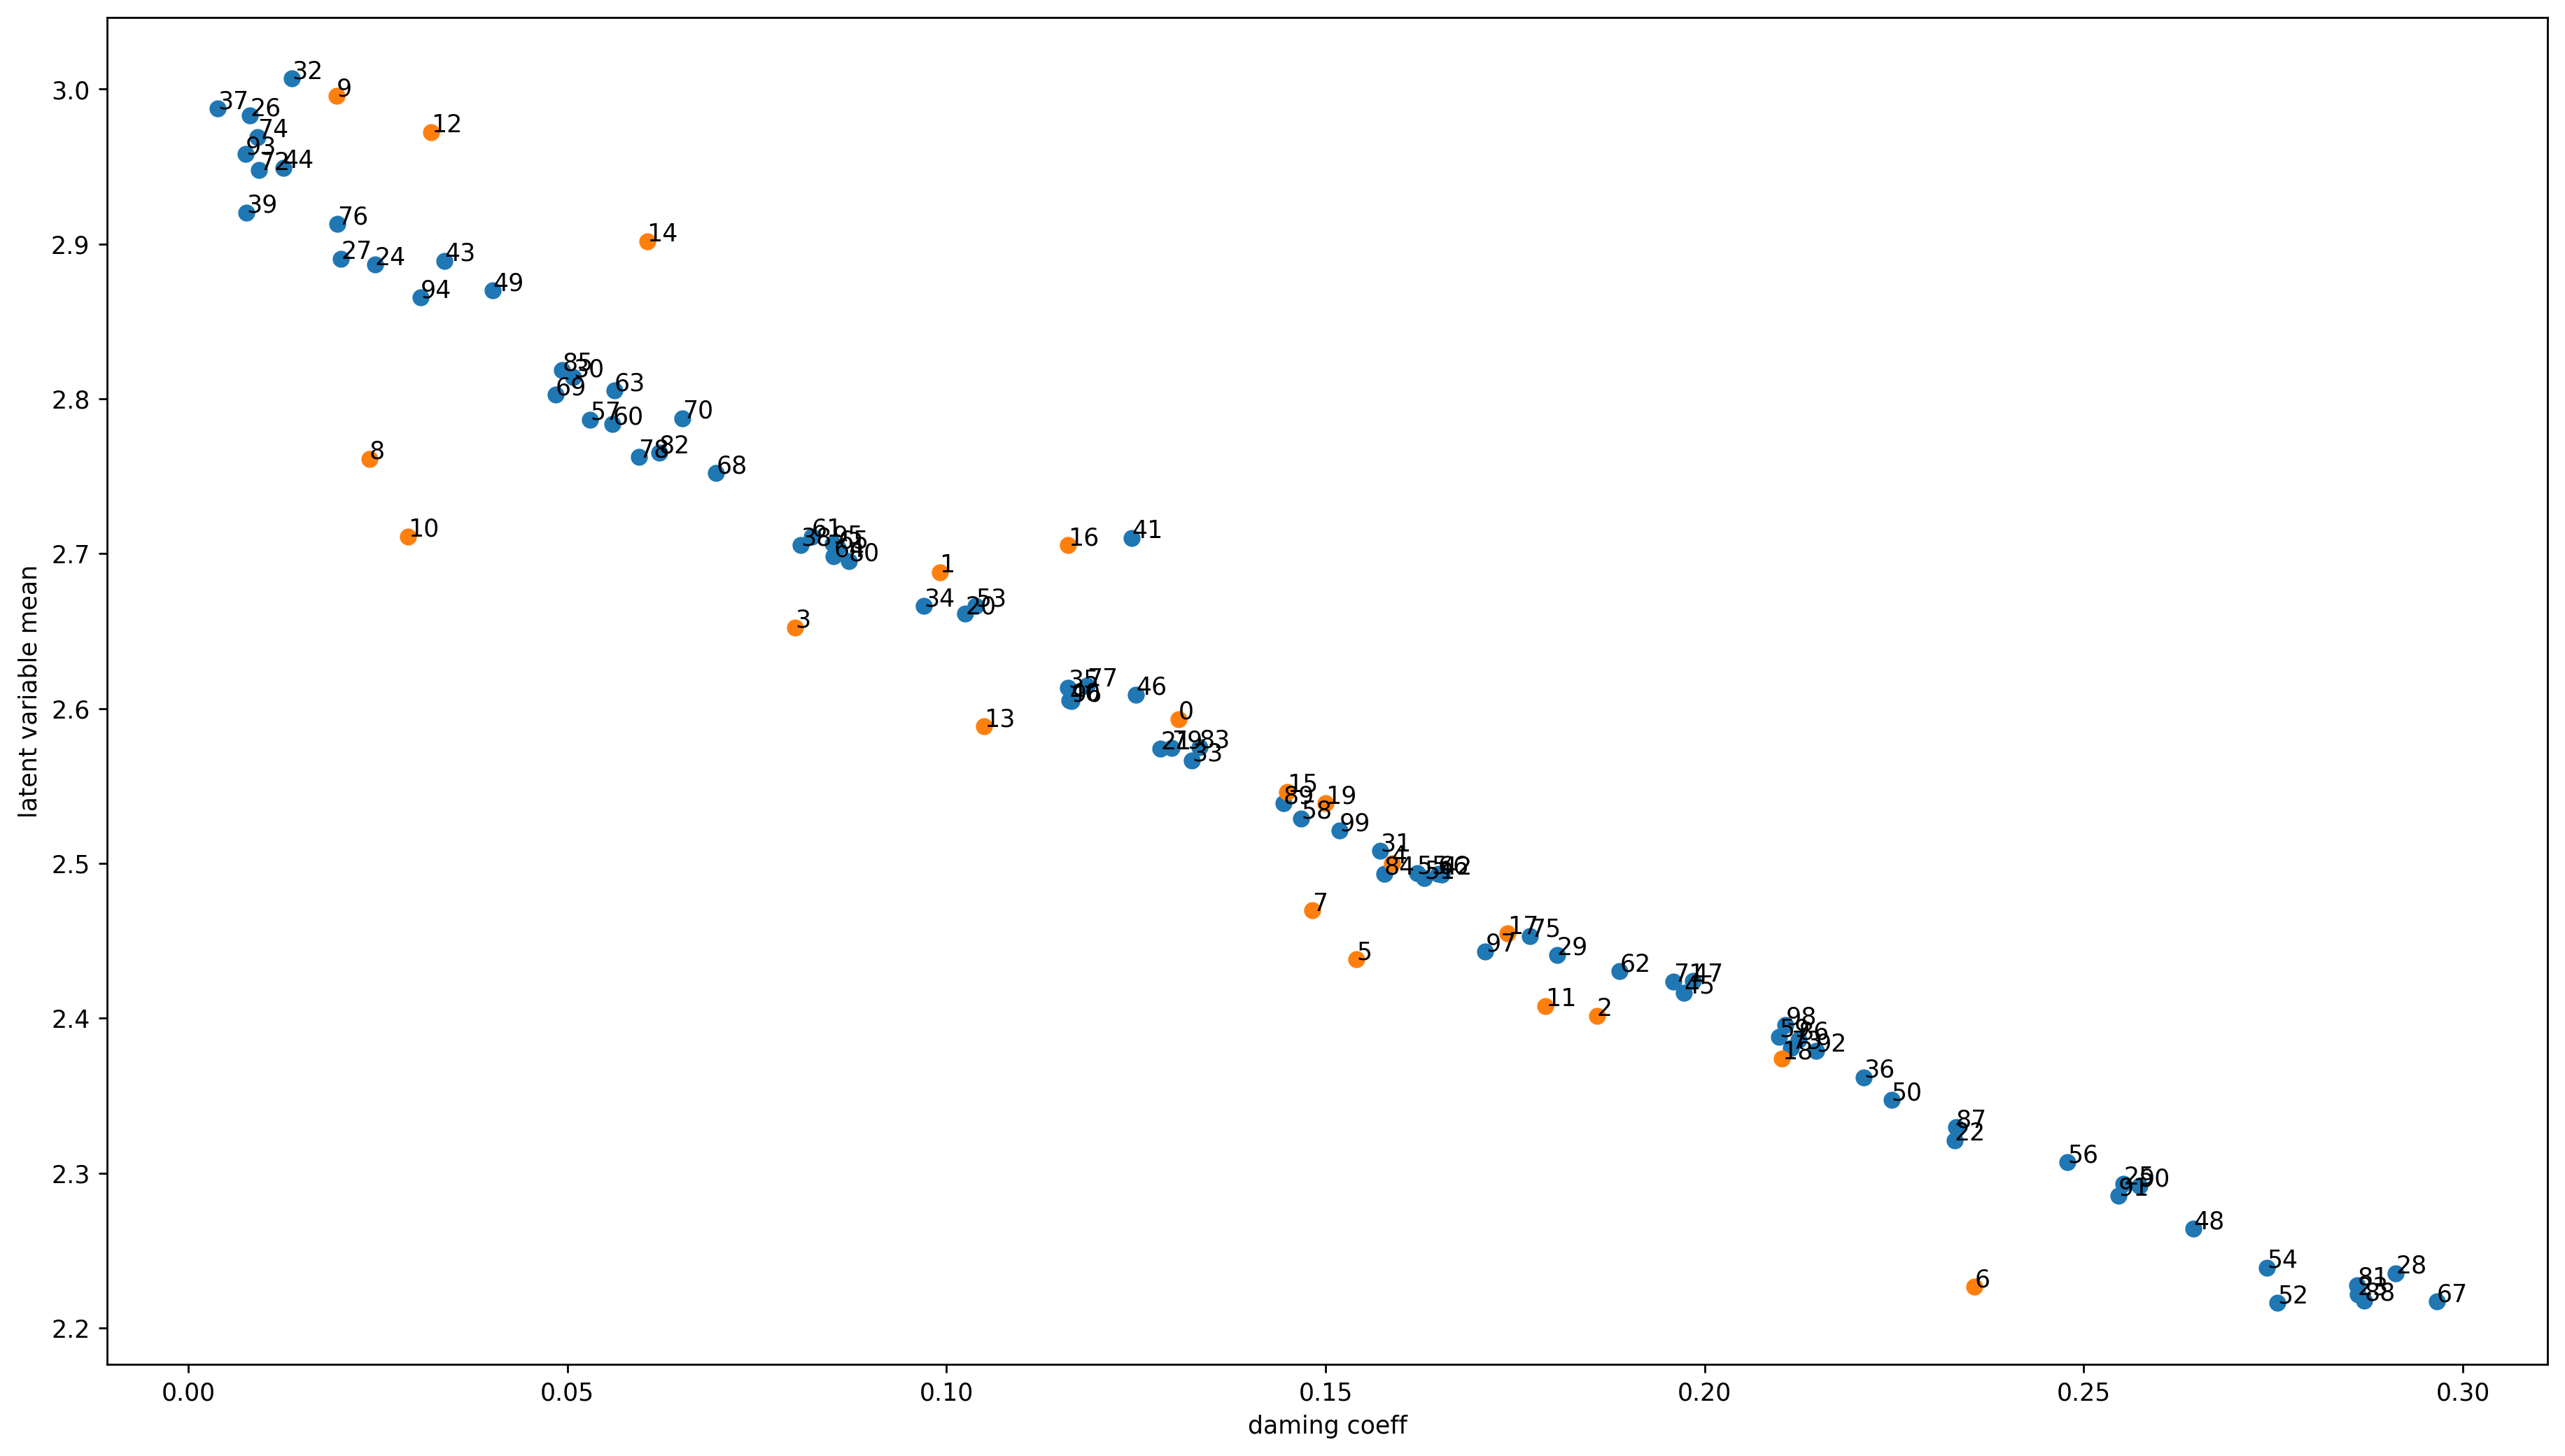

[0.13059672 0.09910045 0.18578129 0.08004818 0.15874263 0.15407344
 0.23560054 0.14827105 0.02389364 0.01958595]
[0.02895927 0.17902359 0.03208371 0.10494789 0.06052297 0.14492095
 0.1160678  0.17400125 0.2102257  0.15000251]
[0.1024841  0.12826379 0.23296776 0.28612267 0.02462848 0.25525515
 0.00816071 0.02014331 0.29117409 0.18054514]
[0.05076763 0.15722006 0.01370369 0.13240648 0.0970624  0.11606697
 0.22102412 0.0039052  0.08081664 0.00766528]
[0.11625703 0.12447175 0.16529337 0.03383286 0.01253931 0.19725372
 0.12502603 0.1984444  0.26449567 0.04018626]
[0.22463336 0.16300357 0.27553759 0.10387137 0.27417464 0.16205745
 0.24787495 0.05301365 0.14677985 0.20985619]
[0.05598814 0.08221778 0.18880792 0.05618596 0.08512674 0.08568112
 0.16484905 0.29655291 0.06963548 0.04843997]
[0.06522073 0.19590615 0.00937427 0.21138825 0.00917684 0.1769346
 0.0196991  0.11854523 0.05940813 0.12971673]
[0.08712802 0.28609799 0.06211495 0.13337228 0.15771997 0.04932573
 0.21239135 0.2331309  0.28702

In [5]:
plt.figure(figsize=(18,10), dpi=250)
np_mulogvar = iwvi.mulogvar_offlinedata.numpy()
plt.xlabel("daming coeff")
plt.ylabel("latent variable mean")

plt.plot(debug_info[iwvi.validdata_num:,1], np_mulogvar[iwvi.validdata_num:,0], "o")
plt.plot(debug_info[:iwvi.validdata_num,1], np_mulogvar[:iwvi.validdata_num,0], "o")
# plt.xlim([-0.05,0.35])
for i in range(len(debug_info)):
    plt.annotate(str(i), xy=(debug_info[i,1],  np_mulogvar[i,0]))
plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.png")
plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.eps")
# plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.pdf")
plt.show()


for i in range(10):
    print(debug_info[i*10 : (i+1)*10,1])
# plt.show()
print("摩擦係数-潜在変数")

In [6]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 9.5367431640625e-07


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `step()` method is not within the observ


 1 4.488547086715698

 2 3.978881359100342

 3 4.0436789989471436

 4 3.91674542427063

 5 4.029597043991089

 6 4.005023717880249

 7 4.102298736572266

 8 3.929727554321289

 9 3.9599456787109375

 10 4.124334096908569

 11 3.979329824447632

 12 4.011691093444824

 13 3.9298343658447266

 14 3.935560703277588

 15 4.056925296783447

 16 3.88173246383667

 17 3.97672176361084

 18 4.038493394851685

 19 3.9241926670074463

 20 4.010808706283569

 21 3.960927963256836

 22 3.913714647293091

 23 3.9673986434936523

 24 4.067549228668213

 25 3.990650177001953

 26 4.077648878097534

 27 4.089659214019775

 28 4.1499104499816895

 29 4.214491367340088

 30 4.017726182937622

 31 3.9506452083587646

 32 4.018099069595337

 33 4.049748420715332

 34 3.9834487438201904

 35 3.941523790359497

 36 3.897794008255005

 37 3.9725449085235596

 38 3.980369806289673

 39 3.9822378158569336

 40 4.1424994468688965

 41 4.0760345458984375

 42 3.985969305038452

 43 3.9945456981658936

 44 4.020

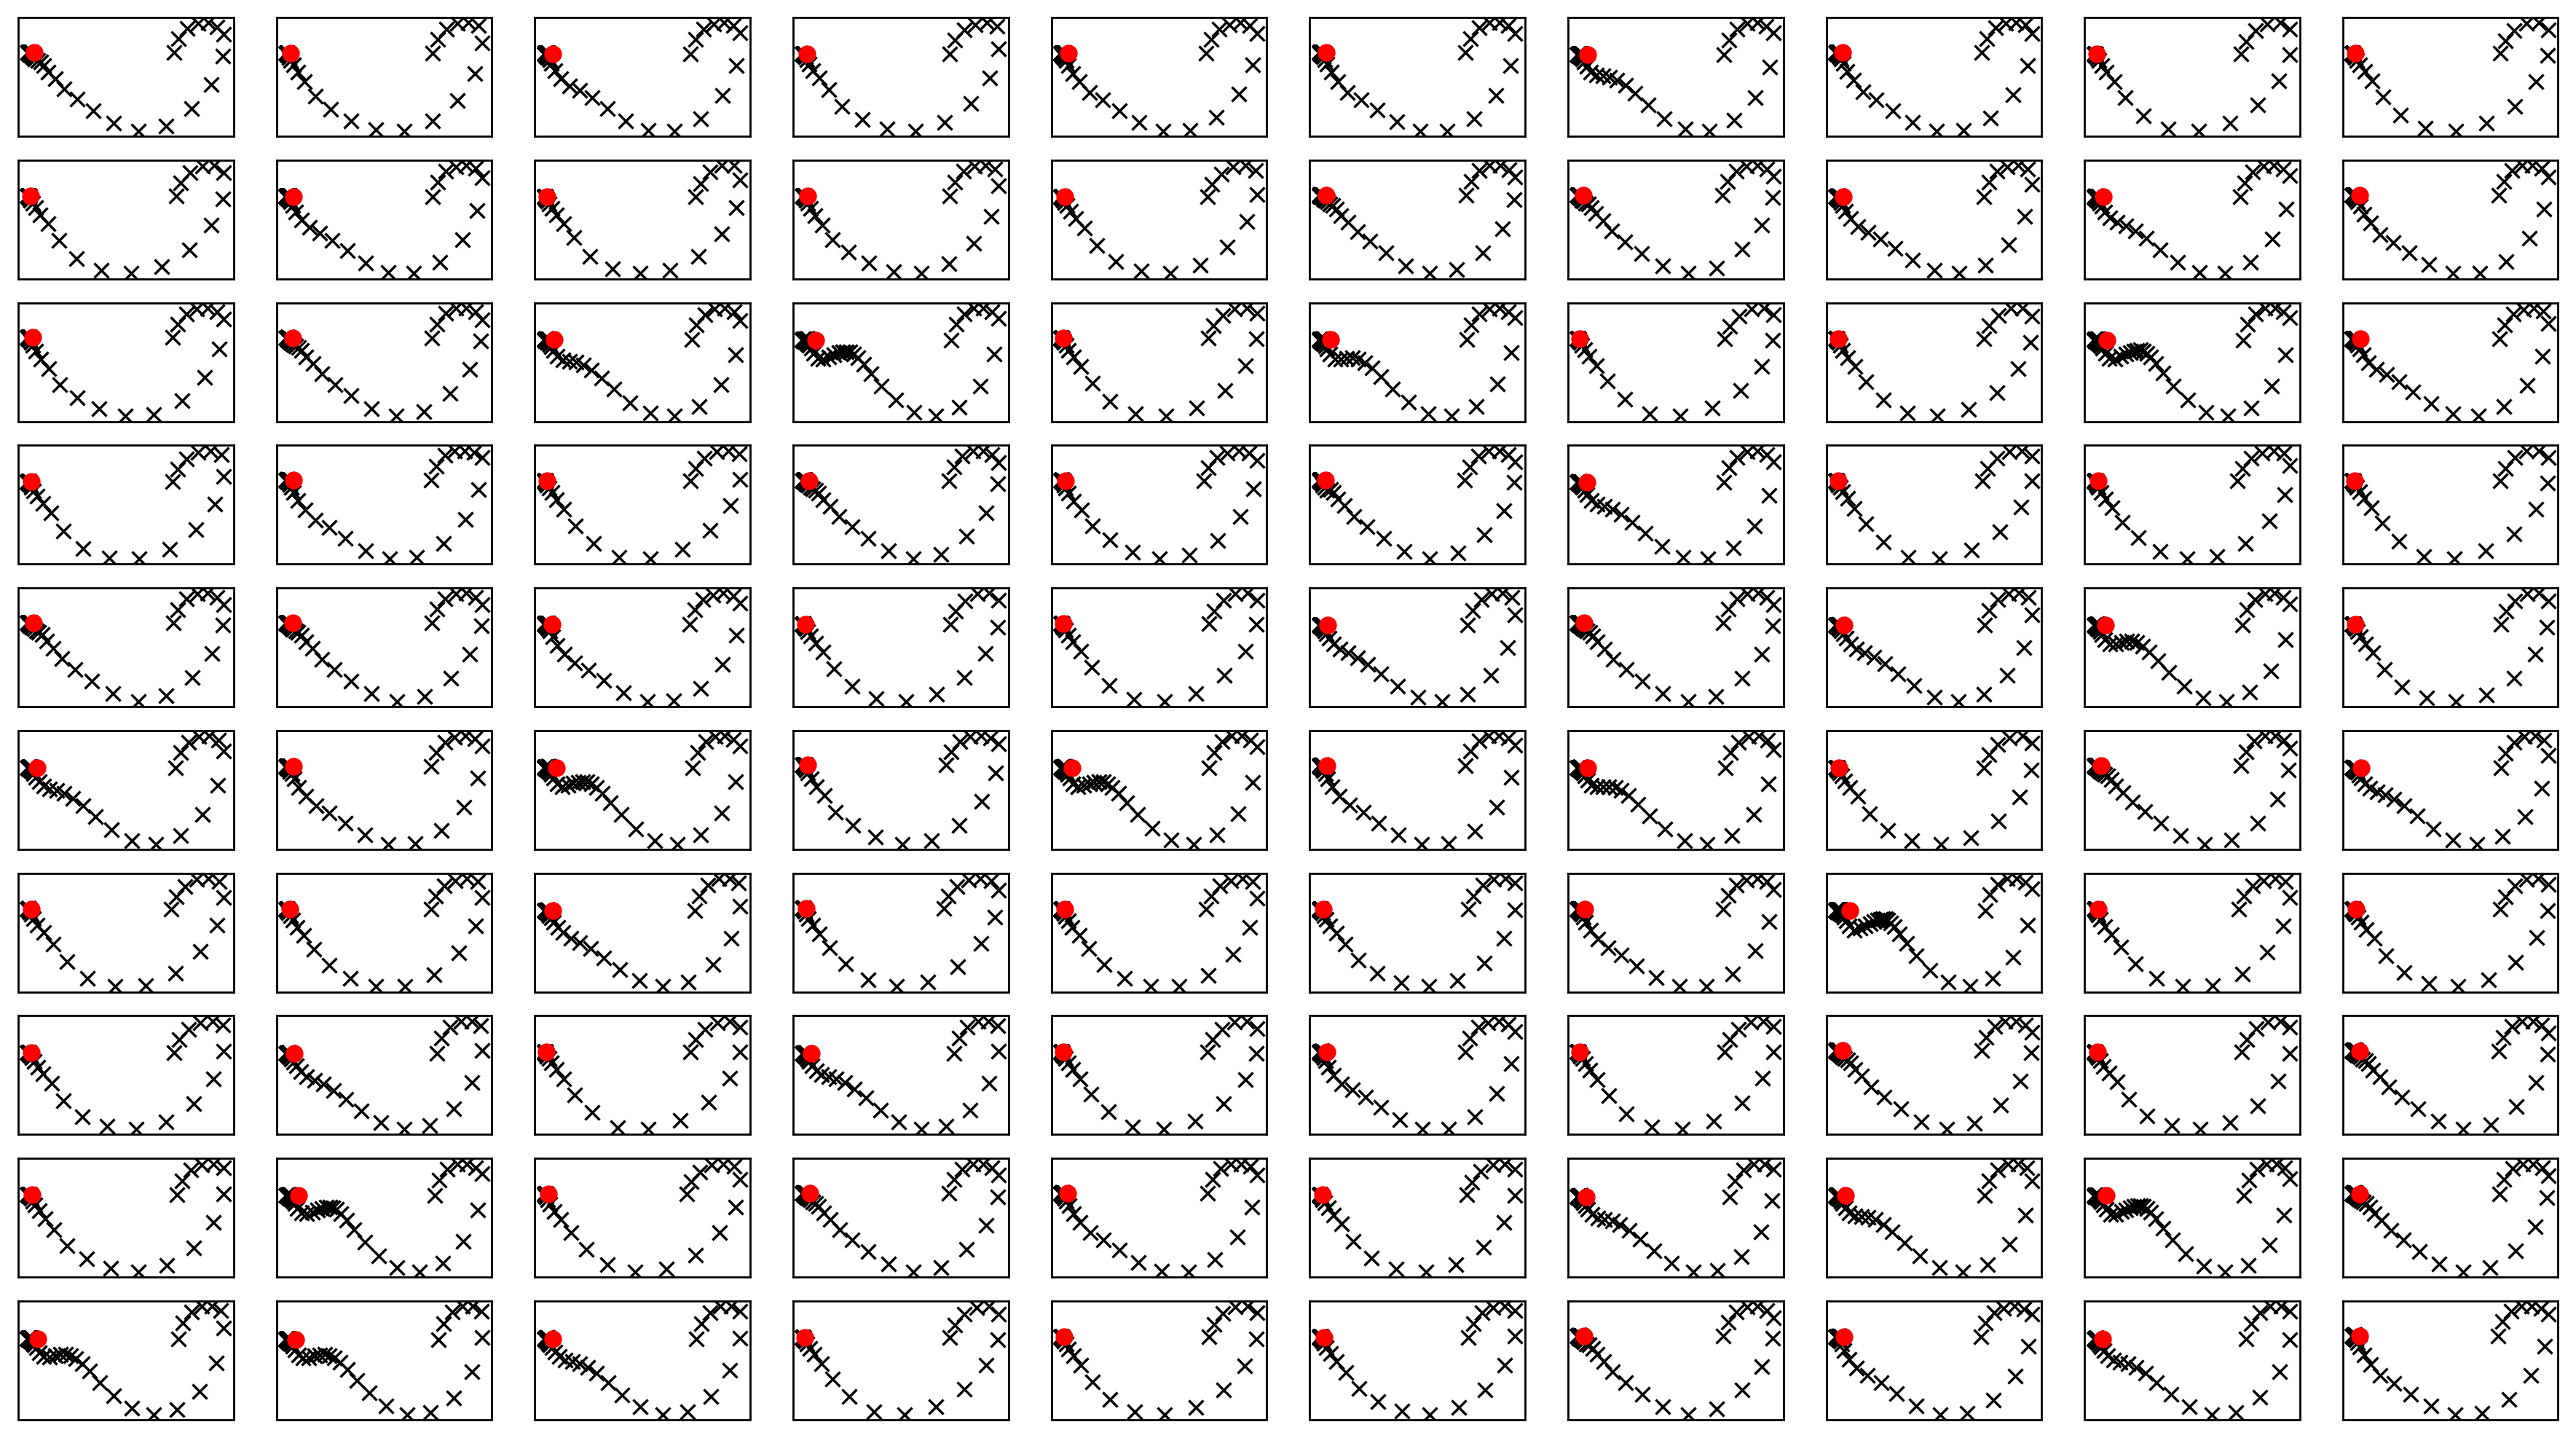

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx") 
    ax_list[-1].plot(0, 0,"ro")
plt.show()

In [8]:
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)


 0 2.384185791015625e-07

 1 4.1492204666137695

 2 8.75042176246643

 3 7.515234470367432

 4 4.276057004928589

 5 3.98246169090271

 6 4.116140365600586

 7 3.9323477745056152

 8 3.9312267303466797

 9 4.118920564651489

 10 4.154826402664185

 11 4.1171875

 12 3.9694695472717285

 13 4.047415733337402

 14 4.079191446304321

 15 3.9985432624816895

 16 4.069557428359985

 17 3.9903173446655273

 18 4.039011240005493

 19 3.890157461166382

 20 3.9053404331207275

 21 4.0346269607543945

 22 4.107251405715942

 23 4.071100473403931

 24 4.101813077926636

 25 3.972410202026367

 26 4.026288270950317

 27 4.041985034942627

 28 4.06914210319519

 29 3.9867491722106934

 30 4.106952667236328

 31 4.1190080642700195

 32 4.137062311172485

 33 4.049538612365723

 34 4.0001890659332275

 35 3.733738899230957

 36 3.9701437950134277

 37 3.8476974964141846

 38 4.164274454116821

 39 3.982896327972412

 40 4.0783851146698

 41 3.9376657009124756

 42 4.057136297225952

 43 3.957214832

実環境方策rollout vs Sim環境方策rollout


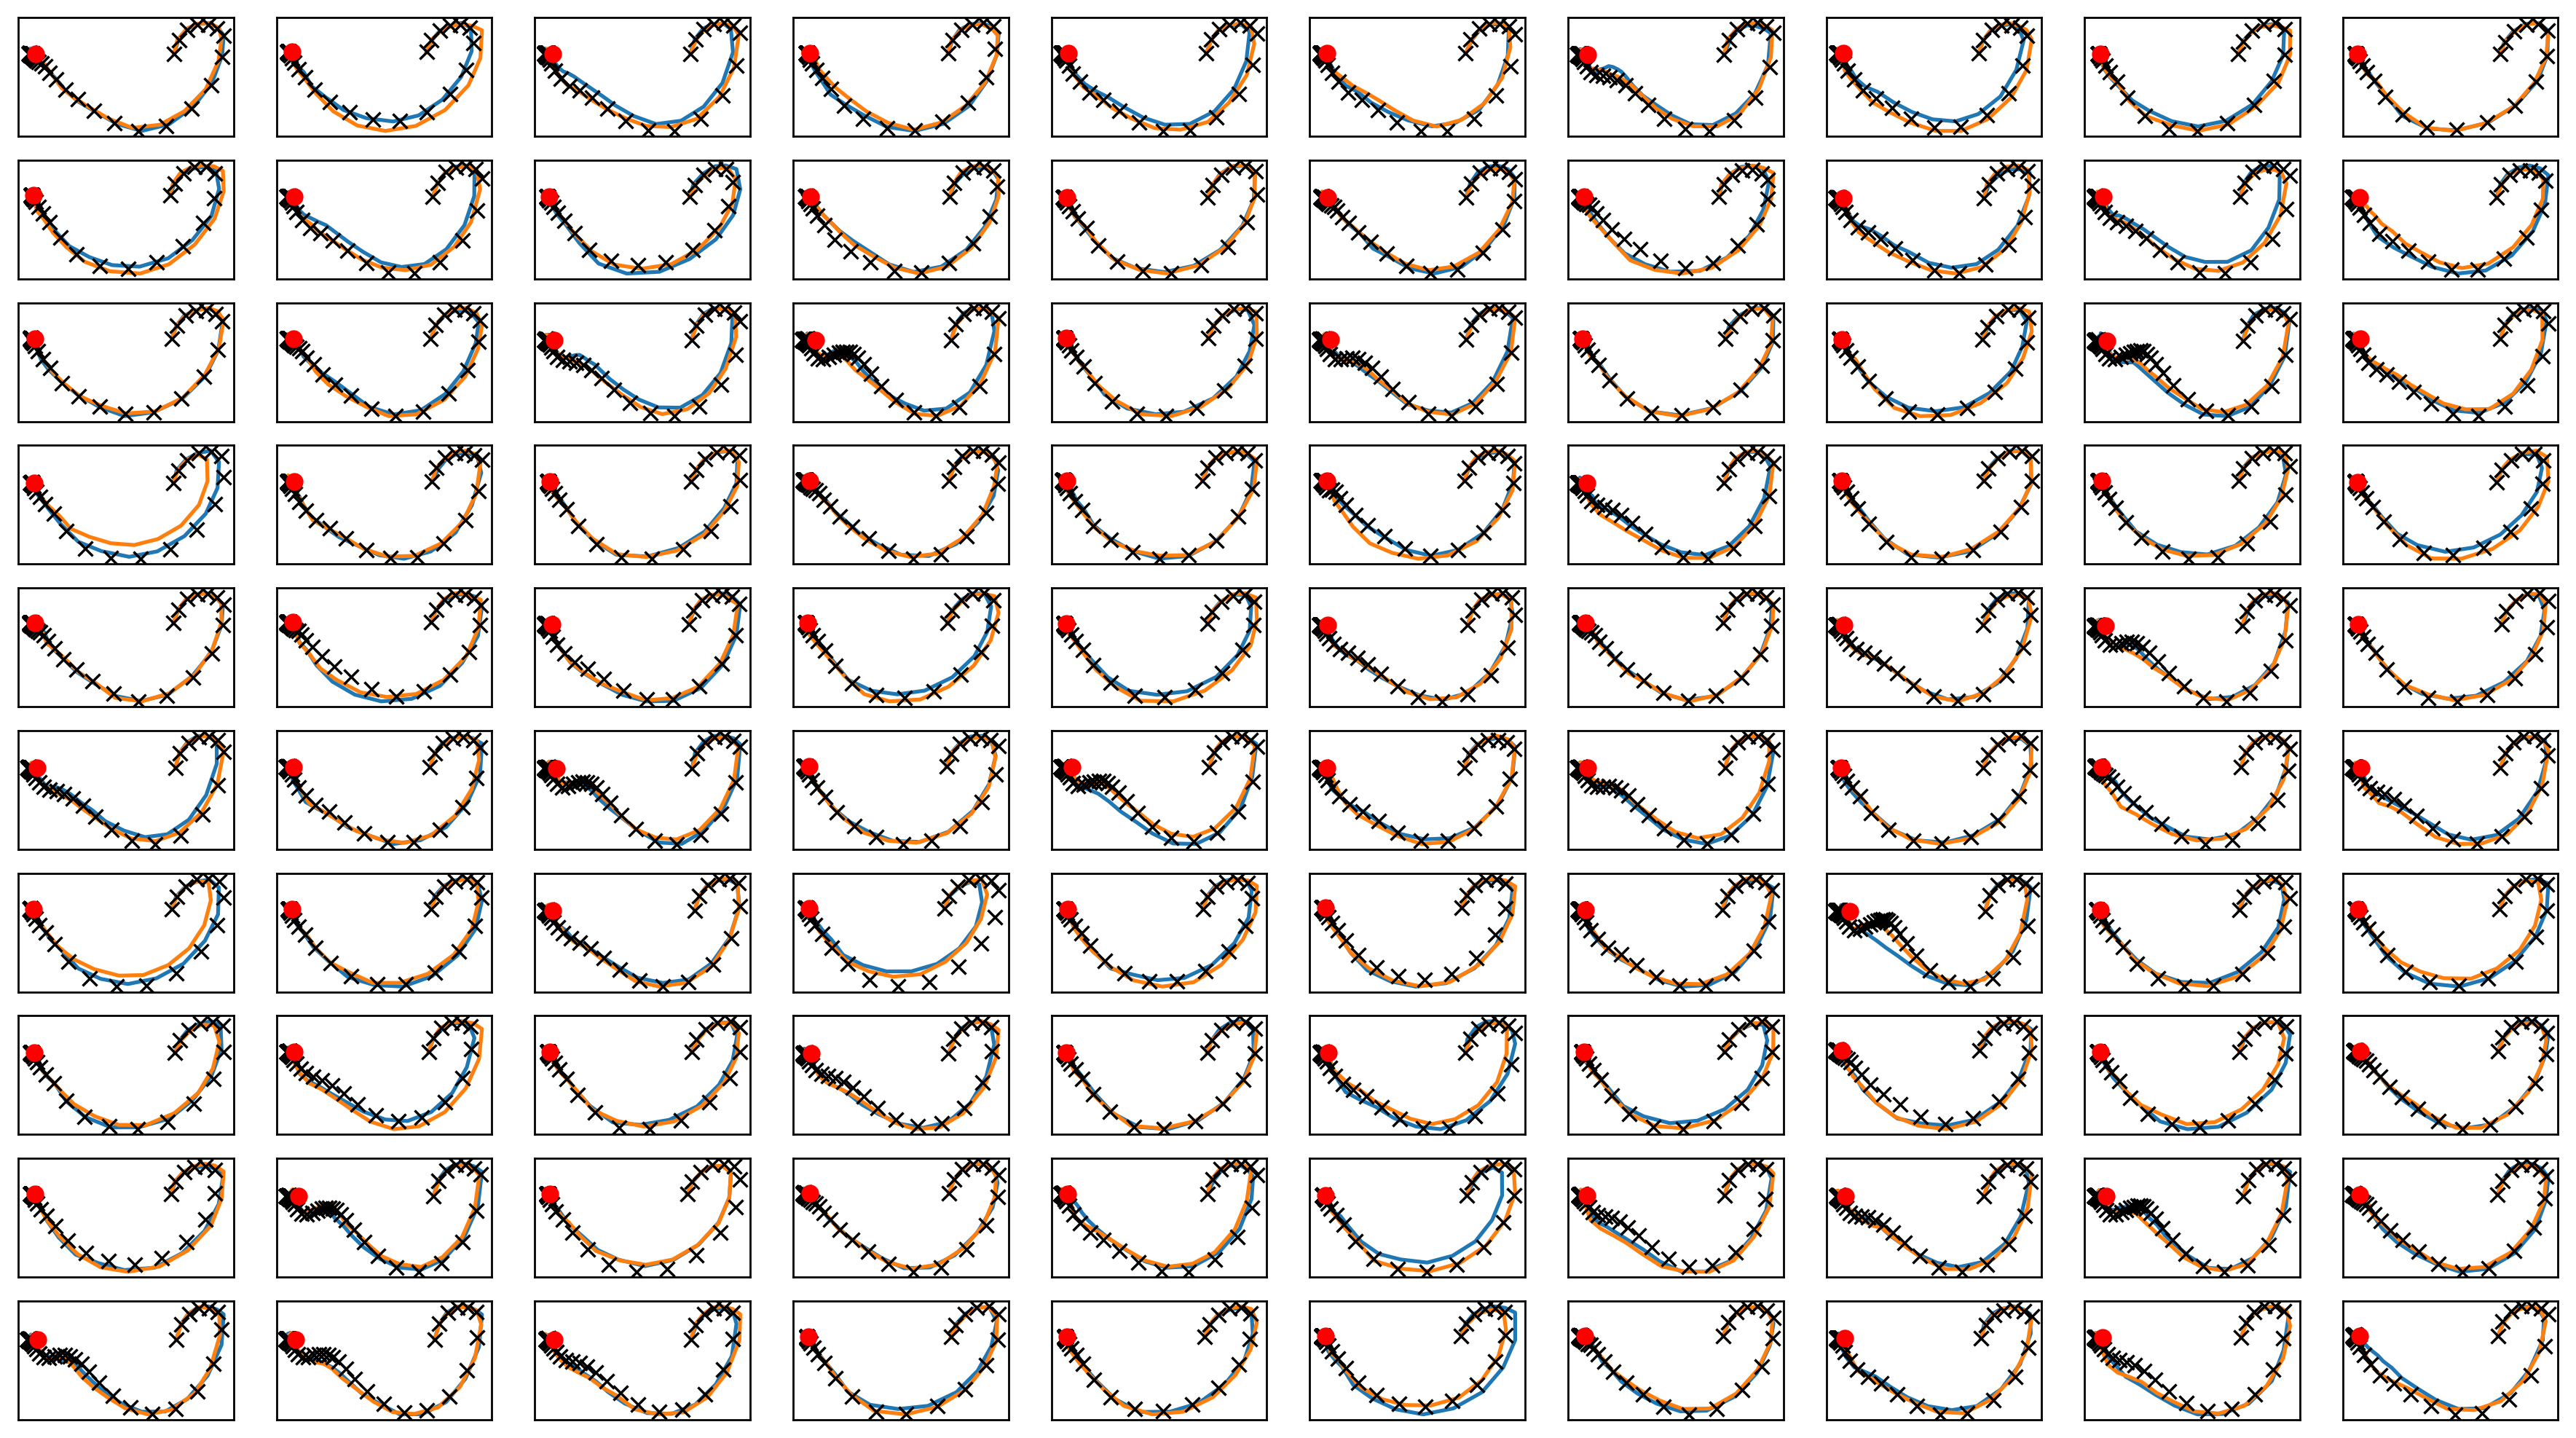

In [9]:

fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
#     ax_list[-1].plot(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1],"kx") 
#     ax_list[-1].plot(iwvi.simenv_rolloutdata[i][:,0], iwvi.simenv_rolloutdata[i][:,1],"o") 
    ax_list[-1].plot(simdata0a[i][:,0], simdata0a[i][:,1]) 
    ax_list[-1].plot(simdata0b[i][:,0], simdata0b[i][:,1]) 
#     ax_list[-1].plot(simdata0c[i][:,0], simdata0c[i][:,1]) 

    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro")
plt.savefig(figfilenamehead+"iter0.png")
# plt.savefig(figfilenamehead+"iter0.pdf")
plt.savefig(figfilenamehead+"iter0.eps")
print("実環境方策rollout vs Sim環境方策rollout")

In [10]:
print(datetime.datetime.now())

2023-07-03 08:14:55.756413
